In [8]:
import spatialdata as sd
import scanpy as sc

In [2]:
stdata = sd.read_zarr("data/ZEN45_with_embeddings.zarr/")

In [46]:
stdata = sd.read_zarr("data/INT1_with_embeddings.zarr")

In [48]:
adata = stdata.tables['table']
embeddings1=adata.obsm['embedding']


In [47]:

embeddings = embeddings1.copy()

In [49]:
embeddings = np.concatenate([embeddings, embeddings1], axis=0)

In [50]:
embeddings.shape

(2168, 768)

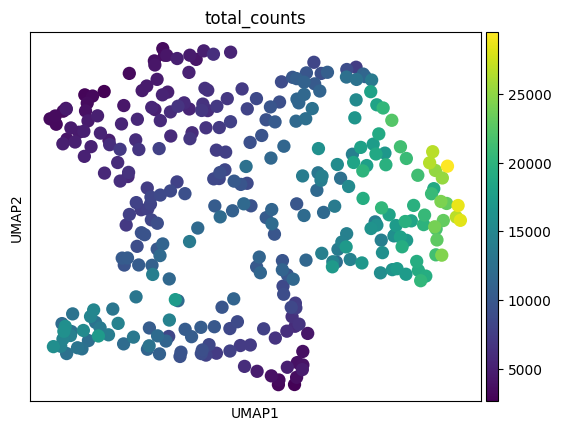

In [10]:
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='total_counts')

In [18]:
adata

AnnData object with n_obs × n_vars = 1084 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'region', 'instance_id'
    var: 'gene_ids', 'feature_types', 'genome', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'spatialdata_attrs', 'pca', 'neighbors', 'umap'
    obsm: 'embedding', 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [55]:
sc.pp.pca(adata, n_comps=50, use_rep='embedding')
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='total_counts')

TypeError: pca() got an unexpected keyword argument 'use_rep'

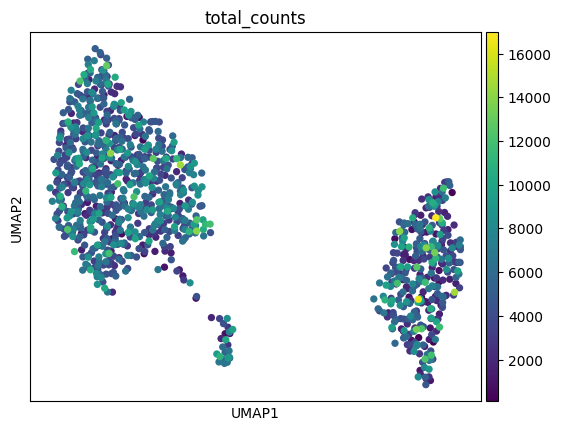

In [53]:
sc.pp.neighbors(adata, use_rep='embedding')
sc.tl.umap(adata)
sc.pl.umap(adata, color='total_counts')

In [63]:
# Get distances from first point to all others
adata.obsp['distances'][0].data


<1x1084 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

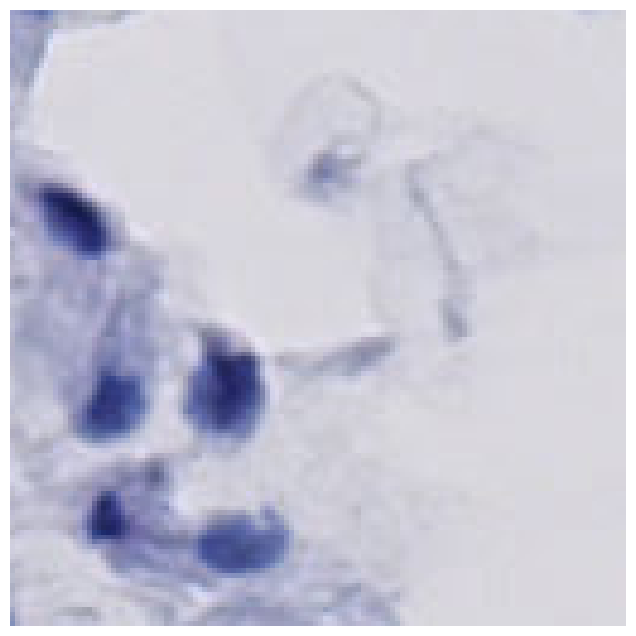

In [59]:
show_patch(0, patchs)

In [ ]:
adata.ob

In [19]:
import numpy as np

In [20]:
def convert_center_to_slicing(coords_center, dimensions, reverse_order=False):
    """
    Convert a center coordinate and dimensions to a slicing.
    If reverse_order is True, the slicing is returned in the reverse order.
    example
        input: np.array([150, 350, 550]), np.array([100, 100, 100])
        output: (slice(100,200), slice(300,400), slice(500,600))
    """
    dimensions = np.array(dimensions).astype(int)
    coords_center = np.array(coords_center).astype(int)
    half_dimensions = np.array(dimensions) // 2
    coords_min = coords_center - half_dimensions
    coords_max = coords_center - half_dimensions + dimensions
    slicing = tuple([slice(min_, max_) for min_, max_ in zip(coords_min, coords_max)])
    if reverse_order:
        return slicing[::-1]
    return slicing

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [56]:
image = np.array(stdata.images["ST_fullres_image"]["scale0"].image)
DIMENSIONS = (128, 128)
geometries = stdata.shapes["locations"]["geometry"]
slicings = geometries.apply(lambda x: (slice(None),) + convert_center_to_slicing((int(x.x), int(x.y)), DIMENSIONS)).values
patchs = []
for slicing in slicings:
    patchs.append(image[slicing].swapaxes(0, 2))

In [58]:
def show_patch(patch_id, patchs):
    # Convert to PIL Image and normalize to 0-255 range
    img = Image.fromarray(patchs[0].astype(np.uint8))

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
results_dict=fetch_similar(test_set, test_sample, top_k=10)

In [ ]:
from tqdm.auto import tqdm
from itertools import islice

def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors"""
    scores = np.dot(emb_one, emb_two) / (np.linalg.norm(emb_one) * np.linalg.norm(emb_two))
    return scores.tolist()

def retrieve_score_dict_for_each_dataset(test_image_embedding, all_candidates_embeddings, dataset_name ):
    """
    Iter on each dataset patches and calculate the similarity score with the embeddings

    return a dictionary containing one column with the dataset_name+patch_id : similarity_score
    """
    sim_scores = compute_scores(test_image_embedding, all_candidates_embeddings)
    candidate_ids=[]
    for id in tqdm(range(len(all_candidates_embeddings))):
        # Create a unique indentifier.
        entry = str(dataset_name) + "_" + str(id)

        candidate_ids.append(entry)

    similarity_mapping = dict(zip(candidate_ids, sim_scores))

    return similarity_mapping

def fetch_similar(image_embedding, candidate_images, top_k=5):
    """Fetches the `top_k` similar images with `image` as the query."""

    all_scores={}
    for dataset_name, patches_embeddings in candidate_images.items():

        output_simscores= retrieve_score_dict_for_each_dataset(image_embedding, patches_embeddings, dataset_name )

        all_scores.update(output_simscores)


    # Sort the mapping dictionary and return top_k candidates.
    similarity_mapping_sorted = dict(
        sorted(all_scores.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    selected_candidate_datasets = list(map(lambda x: x.split("_")[0], id_entries))
    patches_idx = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    similarity_score=list(similarity_mapping_sorted.values())[:top_k]

    results_dict={}
    for i,names in enumerate(id_entries):
        results_dict[names]={'dataset_name':selected_candidate_datasets[i],
                             'patch_id':patches_idx[i],
                             'similarity_score':similarity_score[i]}

    #if we want to output lists then use this
    # return selected_candidate_datasets, patches_idx, similarity_score

    #if prefer to retrieve a dictionnary then output this
    return results_dict